In [16]:
# Revised build v0.3.1
# Changelog:
# Edited the listenForData function to not convert directly to distance
# - rewrote to fit all data in a single csv file
# - Saved the rssi instead
# - Added compute for time interval of data
# - Added an error.csv where all the bad data are stored
# Added Haversine function made be Benj
# Added a function to convert rssi to distance
# Added a function for the tolerance filter
# Changed spacing on the last part

In [17]:
# Import Code
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from kneed import KneeLocator
from scipy.optimize import *
import serial
import time
import math
from math import radians, cos, sin, asin, sqrt
from datetime import datetime as dt
import csv

In [18]:
# Variable declarations
port = 'com19'
baud = 115200

ts = time.localtime() #update time

#Define variables for use
distanceA = list()
distanceB = list()
distanceC = list()
okA = 0
okB = 0
okC = 0
ok = 0
phoneA = 0
phoneB = 1
phoneC = 2

###### CHANGE THIS FOR YOUR DIRECTORY
save_destination = "C:\\Users\\grego\\LoRa Rescue Data 2\\0.3test\\"

# Distance calculation constants
n = 3.2
dro = 1.5
roRSSI = -32

#Trilateration calculation constants
# GNode Coordinates
# Format: A B C
xg = np.array([0,2,0])
yg = np.array([0,0,2])
# GNode Position
# Format: A B C
longg = np.array([0,0,0])
latg = np.array([0,0,0])
# Actual Node Coordinates
xAct = 1.3       #Target x-coordinate
yAct = 1         #Target y-coordinat
# Actual Node Position
longAct = 0
latAct = 0
# For filtering
errorTolerance = 10

In [7]:
# Function Declarations
def listenForData(port,baud):
    #Define variables for use
    print("listening to port "+str(port)+" at "+str(baud))
    arduino = serial.Serial(port, baud)
    rssiA = list()
    rssiB = list()
    rssiC = list()
    phoneA = 0
    phoneB = 0
    phoneC = 0
    okA = 0
    okB = 0
    okC = 0
    ok = 0

    while ok == 0: #will wait until ok is 1. 'ok' will only be 1 when A B C are matching.
        arduino_raw_data = arduino.readline() #read serial data
        decoded_data = str(arduino_raw_data.decode("utf-8")) #convert to utf-8
        data = decoded_data.replace('\n','') #remove \n in the decoded data
        data = data.replace('\r','')
        gatewayID = data[:1] #get gateway ID
        dataID = data[1:2] #get data ID
        data = data[2:] #get data
        if gatewayID == 'A':
            if dataID == '1':
                phoneA = data
                print("\nReceiving Gateway A: 0" + phoneA)
            elif dataID == '2':
                rssiA.append(float(data))
            elif dataID == '3':
                ts = time.localtime() #update time
                timeA = time.strftime("%X", ts) #set timeA to current time
                print("timeA: " + timeA)
                dtn = str(dt.now())
                dtn = dtn[0:19]
                dtn = dtn.replace(':',';')
                rssiA = np.delete(rssiA,len(rssiA)-1)
                rssiA = np.delete(rssiA,len(rssiA)-1)
                okA = 1
        elif gatewayID == 'B':
            if dataID == '1':
                phoneB = data
                print("\nReceiving Gateway B: 0" + phoneB)
            elif dataID == '2':
                rssiB.append(float(data))
            elif dataID == '3':
                ts = time.localtime() #update time
                timeB = time.strftime("%X", ts) #set timeA to current time
                print("timeB: " + timeB)
                rssiB = np.delete(rssiB,len(rssiB)-1)
                rssiB = np.delete(rssiB,len(rssiB)-1)
                okB = 1
        elif gatewayID == 'C':
            if dataID == '1':
                phoneC = data
                print("\nReceiving Gateway C: 0" + phoneC)
            if dataID == '2':
                rssiC.append(float(data))
            if dataID == '3':
                ts = time.localtime() #update time
                timeC = time.strftime("%X", ts) #set timeA to current time
                print("timeC: " + timeC)
                rssiC = np.delete(rssiC,len(rssiC)-1)
                rssiC = np.delete(rssiC,len(rssiC)-1)
                okC = 1
        # Write to CSV, note if data matches
        if phoneA == phoneB == phoneC and okA == 1 and okB == 1 and okC == 1:
            with open(save_destination+'rawData.csv', mode='a') as logs:
                logswrite = csv.writer(logs, dialect='excel', lineterminator='\n')
                logswrite.writerow(['Phone','Time','Gateway A','Gateway B','Gateway C'])
                for i in range(len(rssiA)):
                    logswrite.writerow([phoneA,timeA,rssiA[i],rssiB[i],rssiC[i]])
            start_dt = dt.strptime(timeA, '%H:%M:%S')
            end_dt = dt.strptime(timeC, '%H:%M:%S')
            diff = abs(end_dt - start_dt)
            print("\nA, B, and C received successfully with interval of "+str(diff))
            ok = 1
        elif okA == 1 and okB == 1 and okC == 1:
            print("\nError: Data mismatch, dumping date into error.csv")
            with open(save_destination+'error.csv', mode='a') as logs:
                logswrite = csv.writer(logs, dialect='excel', lineterminator='\n')
                logswrite.writerow(['Time','Gateway A','Gateway B','Gateway C'])
                for i in range(len(rssiA)):
                    logswrite.writerow([phoneA,timeA,rssiA[i],rssiB[i],rssiC[i]])
            rssiA = list()
            rssiB = list()
            rssiC = list()
    return rssiA, rssiB, rssiC, dtn, phoneA #return the variables

def importCSV():
    distanceAf = list()
    distanceBf = list()
    distanceCf = list()
    with open(save_destination+'gatewayAt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                phoneA = row[1]
            elif line_count > 0 and line_count < 59:
                distanceAf.append(row[1])
            elif line_count == 61:
                dtn = row[1]
                dtn = dtn.replace(':',';')
            line_count += 1
    with open(save_destination+'gatewayBt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count > 0 and line_count < 59:
                distanceBf.append(row[1])
            line_count += 1
    with open(save_destination+'gatewayCt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count > 0 and line_count < 59:
                distanceCf.append(row[1])
            line_count += 1
    return distanceAf, distanceBf, distanceCf, dtn, phoneA

def rssiToDist(rssiA,rssiB,rssiC,n,dro,roRSSI):
    distA = list()
    distB = list()
    distC = list()
    rssi = [rssiA,rssiB,rssiC]
    for i in range(len(rssi[0])):
        distA.append(pow(10,((roRSSI-int(rssi[0][i]))/(10*n)))*dro)
        distB.append(pow(10,((roRSSI-int(rssi[1][i]))/(10*n)))*dro)
        distC.append(pow(10,((roRSSI-int(rssi[2][i]))/(10*n)))*dro)
    return distA,distB,distC

def rotateGraph(xg, yg, xAct, yAct):
    def getBcoor(z):
        x = z[0]
        y = z[1]

        F = np.empty((2))
        F[0] = (x**2) + (y**2) - (Rab**2)
        F[1] = ((x-xg[2])**2) + (y**2) - (Rbc**2)
        return F
    def getNcoor(z):
        x = z[0]
        y = z[1]

        F = np.empty((2))
        F[0] = (x**2) + (y**2) - (Ran**2)
        F[1] = ((x-xg[2])**2) + (y**2) - (Rnc**2)
        return F
    zGuess = np.array([1,1])
    if yg[2] != 0:
        notFlat = 1
        xg[2] = -np.sqrt((xg[2]**2)+(yg[2]**2))
        yg[2] = 0
        
        z = fsolve(getBcoor,zGuess)
        xg[1] = z[0]
        yg[1] = -z[1]
        z = fsolve(getNcoor,zGuess)
        xAct = z[0]
        yAct = z[1]
    else:
        notFlat = 0
    return xg, yg, xAct, yAct, notFlat

def trilaterate(distanceAf,distanceBf,distanceCf,xg,yg):
    A = -2*xg[0]+2*xg[1]
    B = -2*yg[0]+2*yg[1]
    C = distanceAf**2-distanceBf**2-xg[0]**2+xg[1]**2-yg[0]**2+yg[1]**2
    D = -2*xg[1]+2*xg[2]
    E = -2*yg[1]+2*yg[2]
    F = distanceBf**2-distanceCf**2-xg[1]**2+xg[2]**2-yg[1]**2+yg[2]**2
    x = (C*E-F*B)/(E*A-B*D)
    y = (C*D-A*F)/(B*D-A*E)
    return x,y

def aveFilter(distanceAf,distanceBf,distanceCf,AfAve,BfAve,CfAve,errorTolerance):
    i = 0
    x = list()
    y = list()
    while i < 60:
        e = 0
        if distanceAf[i] > AfAve + errorTolerance or distanceAf[i] < AfAve - errorTolerance:
            e = 1
        if distanceBf[i] > BfAve + errorTolerance or distanceBf[i] < BfAve - errorTolerance:
            e = 1
        if distanceCf[i] > CfAve + errorTolerance or distanceCf[i] < CfAve - errorTolerance:
            e = 1
        if e != 0:
            distanceAf = np.delete(distanceAf,i)
            distanceBf = np.delete(distanceBf,i)
            distanceCf = np.delete(distanceCf,i)
            if i == len(distanceAf)-1:
                i = 60
                return distanceAf, distanceBf, distanceCf
                continue
        dA = distanceAf[i]
        dB = distanceBf[i]
        dC = distanceCf[i]
        i += 1
        if i == len(distanceAf)-1:
            return distanceAf, distanceBf, distanceCf
            break

# Coordinate Filter
def tolFilter(x,y,errorTolerance):
    i = 0
    while i != 60:
        if i == len(y):
            i = 60
            continue
        e = 0
        dist = np.sqrt(((xAve-x[i])**2)+((yAve-y[i])**2))
        if dist >= errorTolerance:
            #print(str(i)+" - Deleted"+' '+str(x[i])+' '+str(y[i]))
            x = np.delete(x,i)
            y = np.delete(y,i)
        else:
            #print(str(i)+' '+str(x[i])+' '+str(y[i]))
            i += 1
    return x,y

def kmeansOptimize(data):
    # Compute for inertias for every possible number of clusters
    inertia = [] #aka Sum of Squared Distance Errors
    for i in range(1,len(data)):
        kmeans = KMeans(n_clusters=i).fit(data)
        inertia.append(kmeans.inertia_)

    #Determine optimal Number of Clusters based on Elbow
    elbow = KneeLocator(range(1,len(data)),inertia, curve='convex', direction='decreasing')

    #Perform K-means with elbow no. of clusters
    kmeans = KMeans(n_clusters=elbow.knee, n_init=5).fit(data)

    return kmeans,inertia,elbow

def haversine(lat1, lon1, lat2, lon2):

    miles = 3959.87433
    km = 6372.8

    R = km

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    distance = R * c

    return distance

In [19]:
# Listen to COM port and check for errors
rssiA, rssiB, rssiC, dtn, phoneA = listenForData(port,baud)
# For testing import CSVs from gatewayAt etc. *note: all of the imported data are in distances already
# distanceAf, distanceBf, distanceCf, dtn, phoneA = importCSV()

listening to port com19 at 115200

Receiving Gateway A: 09976500649
timeA: 13:48:38

Receiving Gateway B: 09976500649
timeB: 13:48:43

Receiving Gateway C: 09976500649
timeC: 13:48:48

A, B, and C received successfully with interval of 0:00:10


In [20]:
# Convert RSSI to distance
# comment if using imported data
distanceAf, distanceBf, distanceCf = rssiToDist(rssiA,rssiB,rssiC,n,dro,roRSSI)

In [21]:
# Trilateration Part of the Code
for i in range(len(distanceAf)):
    distanceAf[i] = float(distanceAf[i])
    distanceBf[i] = float(distanceBf[i])
    distanceCf[i] = float(distanceCf[i])
# Convert Distances from each GNode to numpy arrays
distanceAf = np.array(distanceAf)
distanceBf = np.array(distanceBf)
distanceCf = np.array(distanceCf)
# Get average distances
AfAve = sum(distanceAf)/len(distanceAf)
BfAve = sum(distanceBf)/len(distanceBf)
CfAve = sum(distanceCf)/len(distanceCf)
# Rotate Graph, comment if not needed
# xg, yg, xAct, yAct, notFlat = rotateGraph(xg, yg, xAct, yAct)

# Due it being unreliable, average filter has been disabled
# Ave Filter Data
dFilteredA, dFilteredB, dFilteredC = aveFilter(distanceAf,distanceBf,distanceCf,AfAve,BfAve,CfAve,errorTolerance)
# Get average of filtered distances
dAfAve = sum(dFilteredA)/len(dFilteredA)
dBfAve = sum(dFilteredB)/len(dFilteredB)
dCfAve = sum(dFilteredC)/len(dFilteredC)

# Trilaterate Data
print("Trilaterating Data...\n")
x,y = trilaterate(distanceAf,distanceBf,distanceCf,xg,yg)
xAve,yAve = trilaterate(AfAve,BfAve,CfAve,xg,yg)

xFilt,yFilt = trilaterate(dFilteredA,dFilteredB,dFilteredC,xg,yg)
# Mean Coordinates after Average Filter
xFiltAve = np.mean(xFilt)
yFiltAve = np.mean(yFilt)

# Tolerance Filter
xFilt,yFilt = tolFilter(x,y,errorTolerance)

Trilaterating Data...



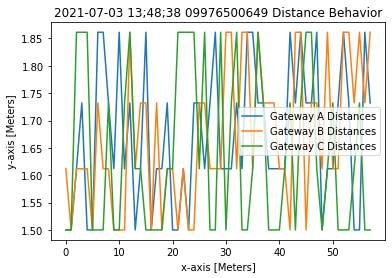

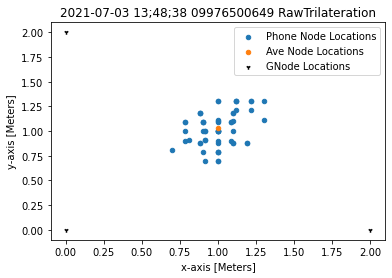

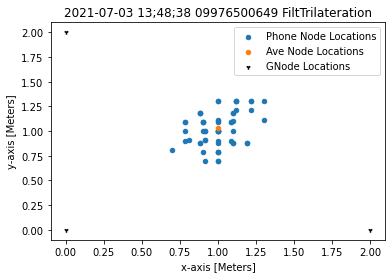

In [22]:
# Plot the behavior of the distance
plt.figure(1)
plt.plot(distanceAf, label='Gateway A Distances')
plt.plot(distanceBf, label='Gateway B Distances')
plt.plot(distanceCf, label='Gateway C Distances')
plt.title(dtn + ' 0' + phoneA  + ' Distance Behavior')
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' DistanceBehavior.jpg')
# Plot the data for trilateration w/o the filters
plt.figure(2)
plt.scatter(x, y, label='Phone Node Locations', cmap='brg', s=20)
plt.scatter(xAve, yAve, label='Ave Node Locations', cmap='brg', s=20)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=20)
plt.title(dtn + ' 0' + phoneA  + ' RawTrilateration')
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' RawTrilateration.jpg')
# Plot the data for trilateration w/o the filters
plt.figure(3)
plt.scatter(xFilt, yFilt, label='Phone Node Locations', cmap='brg', s=20)
plt.scatter(xAve, yAve, label='Ave Node Locations', cmap='brg', s=20)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=20)
plt.title(dtn + ' 0' + phoneA  + ' FiltTrilateration')
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' FiltTrilateration.jpg')

In [23]:
# K-means
# K-means Clustering won't be performed if there is only 1 set of coordinates in the Dataset.
if len(xFilt)<2:
    quit()

# Create numpy array 'data' containing (x,y) coordinates
data = np.array([[xFilt[0],yFilt[0]]])
for i in range(1,len(xFilt)):
    data = np.append(data,[[xFilt[i],yFilt[i]]], axis=0)

# Duplicate Phone Coordinate Filter for K-means Convergence
data = np.unique(data, axis=0) #Eliminate Duplicates in data

kmeans,inertia,elbow = kmeansOptimize(data)
print('Optimal Number of Clusters is', elbow.knee)

Optimal Number of Clusters is 7


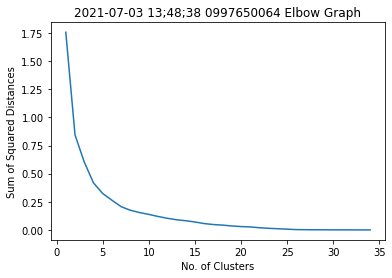

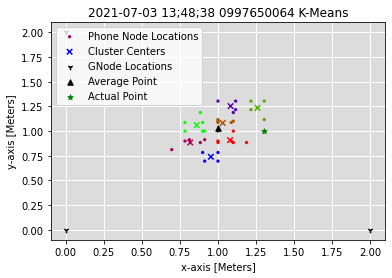

In [24]:
#Elbow Plot
plt.figure(4)
plt.plot(range(1,len(data)), inertia)
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title(dtn + ' 0' + phoneA[0:len(phoneA)-1]  + ' Elbow Graph')
plt.savefig(save_destination + dtn + ' 0' + phoneA[0:len(phoneA)-1] + ' Elbow.jpg') #Change Directory Accordingly

# K-means Plot
plt.figure(5)
plt.scatter(data[:,0],data[:,1], c=kmeans.labels_, label = 'Phone Node Locations', cmap='brg', s=5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c=list(range(1,elbow.knee+1)), marker = 'x', label = 'Cluster Centers', cmap='brg', s=30)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=30)
plt.scatter(xAve, yAve, marker='^', label='Average Point', c='black', s=30)
plt.scatter(xAct, yAct, marker='*', label='Actual Point', c='green', s=30)
plt.grid(linewidth=1, color="w")
ax = plt.gca()
ax.set_facecolor('gainsboro')
ax.set_axisbelow(True)
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.title(dtn + ' 0' + phoneA[0:len(phoneA)-1]  + ' K-Means')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA[0:len(phoneA)-1] + ' K-Means.jpg') #Change Directory Accordingly

In [25]:
# Error Computations
# Computed Position vs. Actual Position
# FUNCTION [5]
compVact = list()
for i in range(len(x)):
    compVact.append(np.sqrt((x[i]-xAct)**2+(y[i]-yAct)**2))

#Computed distanceAf, Bf, Cf
comp_distanceAf = list()
comp_distanceBf = list()
comp_distanceCf = list()
comp_distanceAf = np.sqrt((xAct**2)+(yAct**2))
comp_distanceBf = np.sqrt(((xAct-xg[1])**2)+((yAct-yg[1])**2))
comp_distanceCf = np.sqrt(((xAct-xg[2])**2)+((yAct-yg[2])**2))

#K-means centroid vs. Average Point (dataset average)
centVave = np.sqrt((kmeans.cluster_centers_[:,0]-xAve)**2+(kmeans.cluster_centers_[:,1]-yAve)**2)

#Computed Position vs. K-means centroid
compVcent = np.sqrt([(data[:,0]-kmeans.cluster_centers_[0,0])**2+(data[:,1]-kmeans.cluster_centers_[0,1])**2])
for i in range(1,len(kmeans.cluster_centers_)):
    distance = np.sqrt([(data[:,0]-kmeans.cluster_centers_[i,0])**2+(data[:,1]-kmeans.cluster_centers_[i,1])**2])
    compVcent = np.append(compVcent,distance,axis=0)
# FUNCTION [5]

In [26]:
###############CSV Writing############
with open(save_destination+'Basic.csv', mode='a') as blogs:
    blogswrite = csv.writer(blogs, dialect='excel', lineterminator='\n')
    blogswrite.writerow(['Time',dtn])
    blogswrite.writerow(['Phone#','0'+phoneA[0:len(phoneA)-1]])
    blogswrite.writerow(['gnodeA','gnodeB','gnodeC'])
    blogswrite.writerows([[np.append(xg[0],yg[0]), np.append(xg[1],yg[1]), np.append(xg[2],yg[2])]])
    blogswrite.writerow(['Mean Raw Distances'])
    blogswrite.writerow(['A','B','C'])
    blogswrite.writerow([AfAve,BfAve,CfAve])
    blogswrite.writerow(['Mean Distances with Average Filter'])
    blogswrite.writerow(['A','B','C'])
    blogswrite.writerow([dAfAve,dBfAve,dCfAve])
    blogswrite.writerow(['Mean Raw X and Y Coordinates','','','',np.append(xAve,yAve)])
    blogswrite.writerow(['Mean Coordinates with Average Filter','','','',np.append(xFiltAve,yFiltAve)])
    blogswrite.writerow(['Optimal # of Clusters','',elbow.knee])
    blogswrite.writerow([''])
    blogswrite.writerow([''])
    
with open(save_destination+'Actual.csv', mode='a') as alogs:
    alogswrite = csv.writer(alogs, dialect='excel', lineterminator='\n')
    alogswrite.writerow(['Time',dtn])
    alogswrite.writerow(['Phone#','0'+phoneA[0:len(phoneA)-1]])
    alogswrite.writerow(['Actual Coordinates','',xAct,yAct])
    alogswrite.writerow(['Actual Computed Distances from Gnodes'])
    alogswrite.writerow(['A','B','C'])
    alogswrite.writerow([comp_distanceAf,comp_distanceBf,comp_distanceCf])
    alogswrite.writerow(['Actual Distance vs. Distances with Average Filter'])
    for i in range(np.shape(compVact)[0]):
        alogswrite.writerow([compVact[i]])
    alogswrite.writerow([''])
    alogswrite.writerow([''])

with open(save_destination+'Coordinates.csv', mode='a') as clogs:
    clogswrite = csv.writer(clogs, dialect='excel', lineterminator='\n')
    clogswrite.writerow(['Time',dtn])
    clogswrite.writerow(['Phone#','0'+phoneA[0:len(phoneA)-1]])
    clogswrite.writerow(['Raw X and Y Coordinates'])
    for i in range(np.shape(x)[0]):
        clogswrite.writerow([np.append(x[i],y[i])])
    clogswrite.writerow(['-------------------------------'])
    clogswrite.writerow(['Coordinates with Average Filter'])
    for i in range(np.shape(xFilt)[0]):
        clogswrite.writerow([np.append(xFilt[i],yFilt[i])])
    clogswrite.writerow([''])
    clogswrite.writerow([''])
    
with open(save_destination+'Distances.csv', mode='a') as dlogs:
    dlogswrite = csv.writer(dlogs, dialect='excel', lineterminator='\n')
    dlogswrite.writerow(['Time',dtn])
    dlogswrite.writerow(['Phone#','0'+phoneA[0:len(phoneA)-1]])
    dlogswrite.writerow(['Raw Distances'])
    dlogswrite.writerow(['A','B','C'])
    for i in range(len(distanceAf)):
        dlogswrite.writerow([distanceAf[i],distanceBf[i],distanceCf[i]])
        dlogswrite.writerow(['-------------------------------'])
        dlogswrite.writerow(['Distances with Average Filter'])
        dlogswrite.writerow(['A','B','C'])
    for i in range(len(dFilteredA)):
        dlogswrite.writerow([dFilteredA[i],dFilteredB[i],dFilteredC[i]])    
        dlogswrite.writerow([''])
        dlogswrite.writerow([''])
    
with open(save_destination+'K-Means.csv', mode='a') as klogs:
    klogswrite = csv.writer(klogs, dialect='excel', lineterminator='\n')
    klogswrite.writerow(['Time',dtn])
    klogswrite.writerow(['Phone#','0'+phoneA[0:len(phoneA)-1]])
    klogswrite.writerow(['Inertia'])
    for i in range(len(inertia)):
        klogswrite.writerow([inertia[i]]) 
        klogswrite.writerow(['K-Means Centroid Coordinates'])
    for i in range(elbow.knee):
        klogswrite.writerows([[np.append(kmeans.cluster_centers_[i,0],kmeans.cluster_centers_[i,1])]]) 
        klogswrite.writerow(['K-Means Centroids vs. Mean Coordinates with Average Filter'])
        klogswrite.writerows([centVave])
        klogswrite.writerow(['K-Means Centroids vs. Coordinates w/ Average Filter '])
    for i in range(len(compVcent)):    
        for j in range (len(compVcent[i])):
            klogswrite.writerow([compVcent[i][j]])
            klogswrite.writerow([''])
            klogswrite.writerow([''])